In [1]:
import os, time
import numpy as np
import pickle
from copy import deepcopy
from sklearn.decomposition import PCA
from tqdm import tqdm

# Pytorch
import torch
use_cuda = False
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.ticker
from style import colors
from fig_specs import *

from helpers import Arrow3D

from task_generators import cycling as gen_task
from rnn_model_dt import RNN_Net

Use cpu.


In [6]:
# Select globally what to plot

b_show = np.arange(8)
n_show = len(b_show)
sce_plt = np.array([3, 1])
sce_lbls = np.array(["Aligned", "Oblique"])
n_sce_plt = len(sce_plt)


In [7]:
# Load data
with_noise = True

# Correlation
if with_noise:
    file_name = "neuro_corr.pkl"
else:
    file_name = "neuro_corr_no_noise.pkl"
data_file = os.path.join(data_path, file_name)
with open(data_file, 'rb') as handle:
    [
    task_names, task_lbls, n_task, lbl_sce,
    n_samples, n_sce, n_mi, dim_hid, 
    similarity_with_noise, loss_sce, n_steps_sce, norm_w_sce, norm_h_sce, corr_w_h_sce, 
    corr2_w_h_sce, crit_noise_std_sce, lin_dim_pr_sce, lin_dim_pca_sce, eff_ranks_sce, 
    lr0s_sce, alpha, dist_eucl_sce, dist_ang_sce, svs_cca_sce, 
    dist_ex_eucl_sce, dist_ex_ang_sce, 
    ] = pickle.load(handle)
print('Loaded from ', data_file)


Loaded from  ../../data/oblique/neuro_corr.pkl


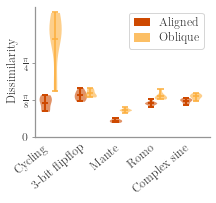

In [9]:
def plot_ang(ax):
    sce_plt = [3, 1]
    n_sce_plt = len(sce_plt)
    ys = np.array(dist_ang_sce)
    lbls = []
    plot_stats(ax, ys, sce_plt, sce_lbls, dx_fac=0.8,)
       
    # Polish
    ax.set_ylabel("Dissimilarity")

    ymax = np.pi/4
    if ymax == np.pi/2:
        ax.set_yticks([0, np.pi/4, np.pi/2])
        # ax.set_yticklabels([0, r"$\pi/4$", r"$\pi/2$"])
        ax.set_yticklabels([0, r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
        ax.set_ylim([0, np.pi/2])
    else:
        ax.set_yticks([0, np.pi/8, np.pi/4])
        # ax.set_yticklabels([0, r"$\pi/8$", r"$\pi/4$"])
        ax.set_yticklabels([0, r"$\frac{\pi}{8}$", r"$\frac{\pi}{4}$"])
        # ax.set_ylim([0, np.pi/4])
        ax.set_ylim([0, None])
    
    ax.legend(loc=1, 
              labelspacing=0.4, handlelength=1.4, handletextpad=0.7, columnspacing=0.5,
              # framealpha=1.,
              frameon=True,
             )
    ax.set_xticks(np.arange(n_task))
    ax.set_xticklabels(task_lbls, rotation=40, ha="right")
    style.fixticks(ax)

fig = plt.figure(figsize=(2.7, 1.8), facecolor='w')
###########################################################
n_rows_da = 1
n_cols_da = 1
gs0 = GridSpec(n_rows_da, n_cols_da)
gs0.update(left=0.1, right=1.0, bottom=0., top=1., wspace=0., hspace=0.2)
axes_da = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols_da)] for k in range(n_rows_da)])
plot_ang(axes_da[0, 0])

## Cycling example

In [10]:
task_name = "cycling"
file_name = "neuro_noisy_cycling_n_512.pkl"
task_lbl = "Cycling"

# Load data
data_file = data_path + file_name

with open(data_file, 'rb') as handle:
    res = pickle.load(handle)
    [
        n_steps, n_samples, gs, out_scales, n_sce, opt_gens, lr0s, n_mi, dim_hid, dim_in, dim_out, 
        dt, rec_step_dt, n_layers, bias, train_in, train_hid, train_out, train_layers, nonlin, 
        gaussian_init, h_0_std, noise_input_std, noise_init_std, noise_hid_std, batch_size, 
        task_params, task_params_ev, n_t_ev, task_ev, n_if, n_ifn, steps, 
        loss_all, output_all, hids_all, h_0_all, sd_if_all, record_train,     
        n_rec_steps, rec_step_width, rec_steps, h_norm_all, dh_norm_all, 
        dw_out_norm_all, dw_rec_norm_all, corr_w_h_all, corr_w_dh_all, 
        which_noises, noise_std_maxs, xlbls, n_wn, n_test, batch_size_test, 
        noise_stds_test, output_test, loss_test, loss_0, loss_thr_noise, crit_noise_std_all,
        n_comp, n_trunc, ranks_trunc, cevr_all, crit_var, lin_dim_all,
        loss_trunc, loss_thr_trunc, eff_ranks_all,
    ] = res
    del res
print('Loaded from ', data_file)
try:
    t_dec = task_params["t_dec"]
    freq = task_params["freq"]
except:
    t_dec = 71
    freq = 0.1

lbl_sce = ["%.1f, %s" % (gs[i_sce], out_scales[i_sce]) for i_sce in range(n_sce)]

Loaded from  ../../data/oblique/neuro_noisy_cycling_n_512.pkl


In [11]:
# Test task for plotting, or others

# Parameters
noise_init_std_ex = noise_init_std
noise_input_std_ex = noise_input_std
noise_hid_std_ex = noise_hid_std
noise_init_std_ex = 0.
noise_input_std_ex = 0.
noise_hid_std_ex = 0.

task_params_ex = deepcopy(task_params)
task_params_ex["t_max"] = 150
# task_params_ex["test"] = True
ts_ex, input_ex, target_ex, mask_ex = gen_task(dim_in, dim_out, dt, **task_params_ex)(batch_size)
noise_input_ex = noise_input_std_ex * np.float32(np.random.randn(*input_ex.shape)) / np.sqrt(dt)
noise_init_ex = noise_init_std_ex * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
task_ex = ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex
ts_ex, input_ex, target_ex, mask_ex, noise_input_ex, noise_init_ex = [to_dev(arr) for arr in task_ex]
n_t_ex = len(ts_ex)
output_ex = np.zeros((*n_mi, batch_size, n_t_ex, dim_out), dtype=np.float32)
hids_ex = torch.zeros((*n_mi, batch_size, n_t_ex, dim_hid))
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.load_state_dict(sd_if_all[1][mi])
    h_0 = h_0_all[mi]
    # Transfer
    net.to(device)
    h_0 = h_0.to(device)
    with torch.no_grad():
        output, hids = net.forward_hid(input_ex + noise_input_ex, 
                                       h_0 + noise_init_ex, 
                                       noise_hid_std_ex, last_time=False)
        output_ex[mi] = output.cpu()
        hids_ex[mi] = hids.cpu()[0]

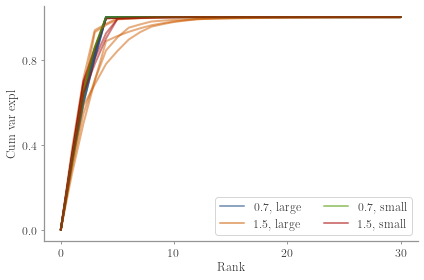

In [12]:
# PCA of hidden dynamics
n_comp = 30
n_trunc = n_comp + 1
ranks_trunc = np.arange(n_trunc)

# Which hidden states to analyze?
plot_ev = False
if plot_ev:
    i_if = 1
    hids_pl = hids_all[i_if]
    task_pl = task_ev
else:
    hids_pl = hids_ex
    task_pl = task_ex

n_t_pl = hids_pl.shape[-2]

# Min and max time for pca
t_pc_min = 30
n_t_pc_min = int(t_pc_min / (dt * rec_step_dt))
n_t_pc_max = n_t_pl
t_pc_max = n_t_pl * (dt * rec_step_dt)
n_t_pc = n_t_pc_max - n_t_pc_min

# Results arrays
h_proj_pl = np.zeros((*n_mi, batch_size, n_t_pl, n_comp))
cevr_pl = np.zeros((n_samples, n_sce, n_comp+1))
evr_pl = np.zeros((n_samples, n_sce, n_comp+1))
for mi in np.ndindex(*n_mi):
    h = hids_pl[mi][:, n_t_pc_min:n_t_pc_max].reshape(-1, dim_hid)
    pca = PCA(n_comp)
    pca.fit(h)
    ps = pca.components_
    h_proj_pl[mi] = hids_pl[mi] @ ps.T
    cevr_pl[mi][1:] = pca.explained_variance_ratio_.cumsum()
    evr_pl[mi][1:] = pca.explained_variance_ratio_

# Plot variance explained
lbl_sce = ["%.1f, %s" % (gs[i_sce], out_scales[i_sce]) for i_sce in range(n_sce)]
n_rows = 1
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    c = colors[i_sce]
    ax = axes[0, 0]
    lbl = lbl_sce[i_sce] if i_s == 0 else None
    ax.plot(ranks_trunc, cevr_pl[mi], c=c, alpha=0.5, label=lbl)
ax.set_ylabel("Cum var expl")
ax.legend(ncol=2)
ax.set_xlabel("Rank")
fig.tight_layout()
style.fixticks(fig)

In [13]:
# Which samples to plot
samples_plt = np.array([
    [0, 1],
    [1, 0],
    [3, 3],
])


## Plot PCA
def plot_pca(axes):
    for ii_s, ii_sce, ii_b in np.ndindex(len(samples_plt), len(sce_plt), len(b_show)):

        i_r = ii_sce
        i_c = ii_s

        ax = axes[i_r, i_c]

        i_s = samples_plt[ii_s, ii_sce]
        i_sce = sce_plt[ii_sce]
        i_b = b_show[ii_b]
        mi = i_s, i_sce
        alphas = 0.7
        cs_if = cs[i_sce][[1, 0]]

        # PCA
        i_if = 1
        h_proj = h_proj_pl[i_s, i_sce, i_b]

        c = cs_ctx[i_b%2]
        # ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
        alpha = 0.3
        ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha)
        # Plot directions
        if i_b in b_show[:2]:
            n_dir = 3
            for i_dir in range(n_dir):
                freq = 0.1
                t_step = int((1/freq) / n_dir / (dt * rec_step_dt))
                i_t = n_t_pc_min + t_step * i_dir
                x = h_proj[i_t:i_t+2, 0]
                y = h_proj[i_t:i_t+2, 1]

                hw = 10
                if plot_3d:
                    z = h_proj[i_t:i_t+2, 2]
                    a = Arrow3D(x, y, z, mutation_scale=25, lw=1, arrowstyle="-|>", color=c)
                    a.set_zorder(10)
                    ax.add_artist(a)
                else:
                    ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
                       length_includes_head=True, head_width=hw, color=c, zorder=10)

        if i_b == b_show[0]:
            if plot_3d:
                # Perspective
                ax.azim = 50
                ax.elev = 30

                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])

Save figure to ../../tex/oblique/figures/neuro_dissimilarity.both


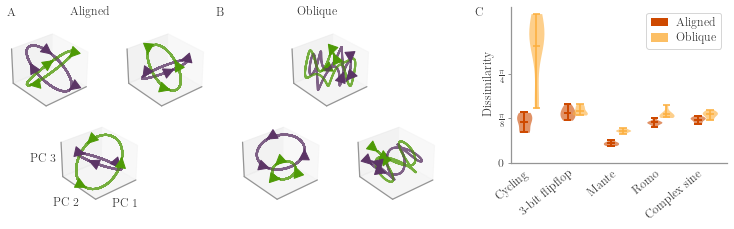

In [15]:
# Join plots
fig_width = 10
fig_height = 2.7
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
plot_3d = True
dim_p = 2 + plot_3d

# Triangular arrangement
left = 0.
right = 0.55
dlr = right - left
bf = dlr/6
fw = (dlr - bf) / 2
w = fw * 5/10 
bl = fw * 3/10
bc = fw * 2/10
fh = 0.6
bots = [-0.1, 0.38]

n_cols = len(samples_plt)
n_rows =  n_sce_plt
axes_pca = np.zeros((n_rows, n_cols), dtype=object)
def add_ax(i_r, i_c, l, b):
    gs0 = GridSpec(1, 1)
    gs0.update(left=l, right=l+w, bottom=b, top=b+fh, wspace=0., hspace=0.)
    axes_pca[i_r, i_c] = fig.add_subplot(gs0[0, 0], projection='3d' if plot_3d else None)
### First group: aligned
i_r = 0
i_c = 0
b = bots[1]
l = 0
add_ax(i_r, i_c, l, b)
i_c = 1
b = bots[1]
l = w + bc
add_ax(i_r, i_c, l, b)
i_c = 2
b = bots[0]
l = bl
add_ax(i_r, i_c, l, b)
### Second group: oblique
i_r = 1
i_c = 0
b = bots[1]
l = fw+bf + bl
add_ax(i_r, i_c, l, b)
i_c = 1
b = bots[0]
l = fw+bf + 0
add_ax(i_r, i_c, l, b)
i_c = 2
b = bots[0]
l = fw+bf + w + bc
add_ax(i_r, i_c, l, b)

plot_pca(axes_pca)

ax = axes_pca[0, 2]
ax.set_xlabel("PC 1", labelpad=-10)
ax.set_ylabel("PC 2", labelpad=-8.2)
ax.set_zlabel("PC 3", labelpad=-10)


###########################################################
n_rows_da = 1
n_cols_da = 1
gs0 = GridSpec(n_rows_da, n_cols_da)
gs0.update(left=right+0.15, right=1.0, bottom=0.2, top=1, wspace=0., hspace=0.2)
axes_da = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols_da)] for k in range(n_rows_da)])
plot_ang(axes_da[0, 0])

##############################################################################
# Label plots
y = 1.
plt.gcf().text(0.115, y, "Aligned", ha='center', va='top', fontsize=fs)
plt.gcf().text(0.43, y, "Oblique", ha='center', va='top', fontsize=fs)
plt.gcf().text(0., y, flbs[0], ha='left', va='top', fontsize=fs)
plt.gcf().text(0.29, y, flbs[1], ha='left', va='top', fontsize=fs)
plt.gcf().text(0.65, y, flbs[2], ha='left', va='top', fontsize=fs)

fig_name = "neuro_dissimilarity"
# style.saving_fig(fig, figure_path, fig_name, data_type='both')

In [86]:
# Frequencies for FFT
dt_rec = rec_step_dt * dt
freqs = np.fft.fftfreq(n_t_pc, dt_rec)
mf = freqs >= 0
freqs = freqs[mf]
n_f = len(freqs)
ps_pl = np.zeros((*n_mi, batch_size, n_f, n_comp))
for mi in np.ndindex(*n_mi):
    h_proj = h_proj_pl[mi][:, n_t_pc_min:n_t_pc_max]

    # Power spectra via FFT
    ps = np.abs(np.fft.fft(h_proj, axis=-2)[:, mf, :])**2
    ps_pl[mi] = ps
    
# Other global parameters for PSD
n_comp_show = 6
f_max_show = 0.45
mf_show = freqs <= f_max_show
n_f_max = (mf_show).sum()



Save figure to ../../tex/oblique/figures/cycling_freqs.both


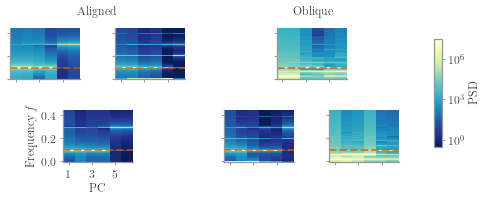

In [106]:
# Colormap for plotting
cmap_psd = mpl.cm.YlGnBu_r
vmin_psd = -0.5 #np.log10(ps_pl).min()
vmax_psd = 7.5 #np.log10(ps_pl).max()

# PSD, Triangular arrangement
left = 0.
right = 0.9
dlr = right - left
bf = dlr/10
fw = (dlr - bf) / 2
w = fw * 4/10 
bl = fw * 3/10
bc = fw * 2/10
fh = 0.6
bots = [0., 0.38]

n_cols = len(samples_plt)
n_rows =  n_sce_plt

fig_width = 6
fig_height = 3
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
axes = np.zeros((n_rows, n_cols), dtype=object)
def add_ax(i_r, i_c, l, b):
    gs0 = GridSpec(1, 1)
    gs0.update(left=l, right=l+w, bottom=b, top=b+fh, wspace=0., hspace=0.)
    axes[i_r, i_c] = fig.add_subplot(gs0[0, 0])
### First group: aligned
i_r = 0
i_c = 0
b = bots[1]
l = 0
add_ax(i_r, i_c, l, b)
i_c = 1
b = bots[1]
l = w + bc
add_ax(i_r, i_c, l, b)
i_c = 2
b = bots[0]
l = bl
add_ax(i_r, i_c, l, b)
### Second group: oblique
i_r = 1
i_c = 0
b = bots[1]
l = fw+bf + bl
add_ax(i_r, i_c, l, b)
i_c = 1
b = bots[0]
l = fw+bf + 0
add_ax(i_r, i_c, l, b)
i_c = 2
b = bots[0]
l = fw+bf + w + bc
add_ax(i_r, i_c, l, b)

###############################3
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_s = samples_plt[i_c, i_r]
    i_sce = sce_plt[i_r]
    mi = i_s, i_sce
    z = np.log10(ps_pl[mi][:, mf_show, :n_comp_show].mean(0)) 
    ax.imshow(z, interpolation='none', origin='lower', aspect=0.08, 
              cmap=cmap_psd, vmin=vmin_psd, vmax=vmax_psd,)
    Df = freqs[mf_show][-1] - freqs[mf_show][0]
    df = freqs[1] - freqs[0]
    ax.axhline((freq-df/2) * n_f_max / Df, ls='--', c=colors[1], alpha=0.7)
    yticklabels = np.array([0, 0.2, 0.4])
    yticks = (yticklabels) * n_f_max / Df
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    
    xticks = np.arange(0, n_comp_show)
    xticklabels = np.zeros(len(xticks), dtype=object)
    xticklabels[::2] = xticks[::2] + 1
    xticklabels[1::2] = None
    ax.set_xticks(xticks)
    # Only one corner for axes labels
    if i_r == 0 and i_c == 2:
        ax.set_xlabel("PC")
        ax.set_ylabel("Frequency $f$")
        ax.set_xticklabels(xticklabels)
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
# Colorbar
gs0 = GridSpec(1, 1)
gs0.update(left=0.98, right=1, bottom=0.25, top=0.75, wspace=0., hspace=0.)
ax_cbar = fig.add_subplot(gs0[0, 0])
values = np.linspace(vmin_psd, vmax_psd, 200)
ticks = np.array([0, 3, 6])
cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap_psd, values=values,
                                ticks=ticks,
                                orientation='vertical', label=r"PSD")
cbar.ax.set_yticklabels([r"$10^%d$"%t for t in ticks])

# Plot title
y = 0.85
plt.gcf().text(0.2, y, "Aligned", ha='center', va='bottom', fontsize=fs)
plt.gcf().text(0.7, y, "Oblique", ha='center', va='bottom', fontsize=fs)
style.fixticks(fig)
fig_name = "cycling_freqs"
# style.saving_fig(fig, figure_path, fig_name, data_type='both')

/tmp/ipykernel_25736/2668075446.py:64: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 8


Save figure to ../../tex/oblique/figures/cycling_pca_samples.both


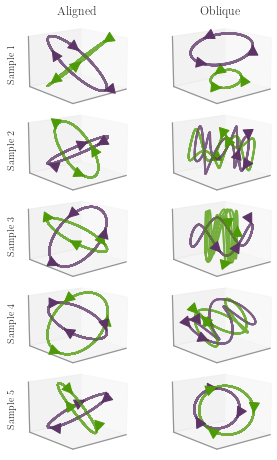

In [110]:
## Plot PCA
samples_plt_a = np.arange(n_samples)
n_rows = len(samples_plt_a)
b_show = np.arange(8)
n_show = len(b_show)
n_cols =  n_sce_plt

fig_width = 4
fig_height = 1.2 * n_rows
fig = plt.figure(figsize=(fig_width, fig_height), facecolor='w')
plot_3d = True
dim_p = 2 + plot_3d
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.)
axes = np.array([[fig.add_subplot(gs0[k, j], projection='3d' if plot_3d else None)
                      for j in range(n_cols)] for k in range(n_rows)])


ts_pl, input_pl, target_pl, mask_pl, _, _ = task_pl
for i_r, i_bs, i_c in np.ndindex(n_rows, n_show, n_cols):
    ax = axes[i_r, i_c]
    i_s = samples_plt_a[i_r]
    i_sce = sce_plt[i_c]
    mi = i_s, i_sce
    alphas = 0.7
    cs_if = cs[i_sce][[1, 0]]
    i_b = b_show[i_bs]
    
    # PCA
    i_if = 1
    h_proj = h_proj_pl[i_s, i_sce, i_b]
    input = input_pl[i_b]
    target = target_pl[i_b]
    mask = mask_pl[i_b]
    
    c = cs_ctx[i_b%2]
    # ax.plot(*h_proj[:n_t_pc_min, :dim_p].T, '--', c=c, alpha=alpha)
    alpha = 0.3
    ax.plot(*h_proj[n_t_pc_min:, :dim_p].T, '-', c=c, alpha=alpha)
    # Plot directions
    if i_b in b_show[:2]:
        n_dir = 3
        for i_dir in range(n_dir):
            freq = 0.1
            t_step = int((1/freq) / n_dir / (dt * rec_step_dt))
            i_t = n_t_pc_min + t_step * i_dir
            x = h_proj[i_t:i_t+2, 0]
            y = h_proj[i_t:i_t+2, 1]

            hw = 10
            if plot_3d:
                z = h_proj[i_t:i_t+2, 2]
                a = Arrow3D(x, y, z, mutation_scale=25, lw=1, arrowstyle="-|>", color=c)
                a.set_zorder(10)
                ax.add_artist(a)
            else:
                ax.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], lw=0.2, shape='full',
                   length_includes_head=True, head_width=hw, color=c, zorder=10)

    if i_b == b_show[0]:
        if plot_3d:
            # Perspective
            ax.azim = 50
            ax.dist = 8
            ax.elev = 14
            
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

        if i_s == 0:
            ax = axes[0, i_c]
            lbl = ["Aligned", "Oblique"][i_c]
            ax.set_title(lbl)
        if i_c == 0:
            ax = axes[i_r, 0]
            fig.text(-0.25, 0.5, "Sample %d" %(i_s+1), ha='center', va='center', rotation=90, 
                    transform=ax.transAxes)
        
style.fixticks(fig)

fig_name = task_name + "_pca_samples"
# style.saving_fig(fig, figure_path, fig_name, data_type='both')